In [1]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# START

In [2]:
import sys
sys.path.insert(0, r'../../../quetzal')
from quetzal.model import stepmodel
import pandas as pd

PyTables is not installed. No support for HDF output.


In [3]:
training_folder = '../../'
plot_path = training_folder + 'outputs/plot/'

In [4]:
sm = stepmodel.read_zippedpickles(training_folder + r'models/base/walk_model'.format(scen=scenario))

zone_to_transit: 100%|██████████| 29/29 [00:01<00:00, 27.23it/s]          


# ROUTE BREAKER: rail submodel

In [5]:
# add required fields
sm.links['length'] = sm.links['road_length']

In [6]:
rail = sm.copy()
rail.links = rail.links.loc[rail.links['route_type'].isin(['tram', 'subway', 'rail'])] 

In [7]:
rail.step_pt_pathfinder(
    broken_routes=True,
    broken_modes=False,
    route_column='route_short_name',
    mode_column='route_type',
    speedup=True,
    boarding_time=300
)

start publicpathfinder


breaking route: T3B : 100%|██████████| 24/24 [00:07<00:00,  3.40it/s]


path_analysis


path_analysis: 100%|██████████| 34488/34488 [00:00<00:00, 48021.06it/s]


In [8]:
rail.pt_los.set_index(['origin', 'destination'])['pathfinder_session'].value_counts()

route_breaker    22388
best_path        12100
Name: pathfinder_session, dtype: int64

# MODE BREAKER

In [9]:
sm.road_links['walk_time'] = sm.road_links['length'] / (3/3.6) # 3 km/h

In [10]:
sm.links.drop(['index'], axis=1,inplace=True, errors='ignore')
sm.step_pt_pathfinder(
    broken_routes=False,
    broken_modes=True,
    route_column='route_short_name',
    boarding_time=300,
    prune=False
)

start publicpathfinder
build_mode_combinations
find_broken_mode_paths


  0%|          | 0/16 [00:00<?, ?it/s]

breaking modes: set() : 100%|██████████| 16/16 [00:07<00:00,  2.27it/s]                           


path_analysis


path_analysis: 100%|██████████| 69580/69580 [00:01<00:00, 47960.16it/s]


# CONCATENATION

In [11]:
both = sm.copy()

In [12]:
both.pt_los = pd.concat(
    [sm.pt_los, rail.pt_los]
).drop_duplicates(subset=['path'])

In [13]:
both.pt_los.set_index(['origin', 'destination'])['pathfinder_session'].value_counts()

mode_breaker     69580
route_breaker    18273
Name: pathfinder_session, dtype: int64

100%|██████████| 8/8 [00:16<00:00,  2.03s/it]


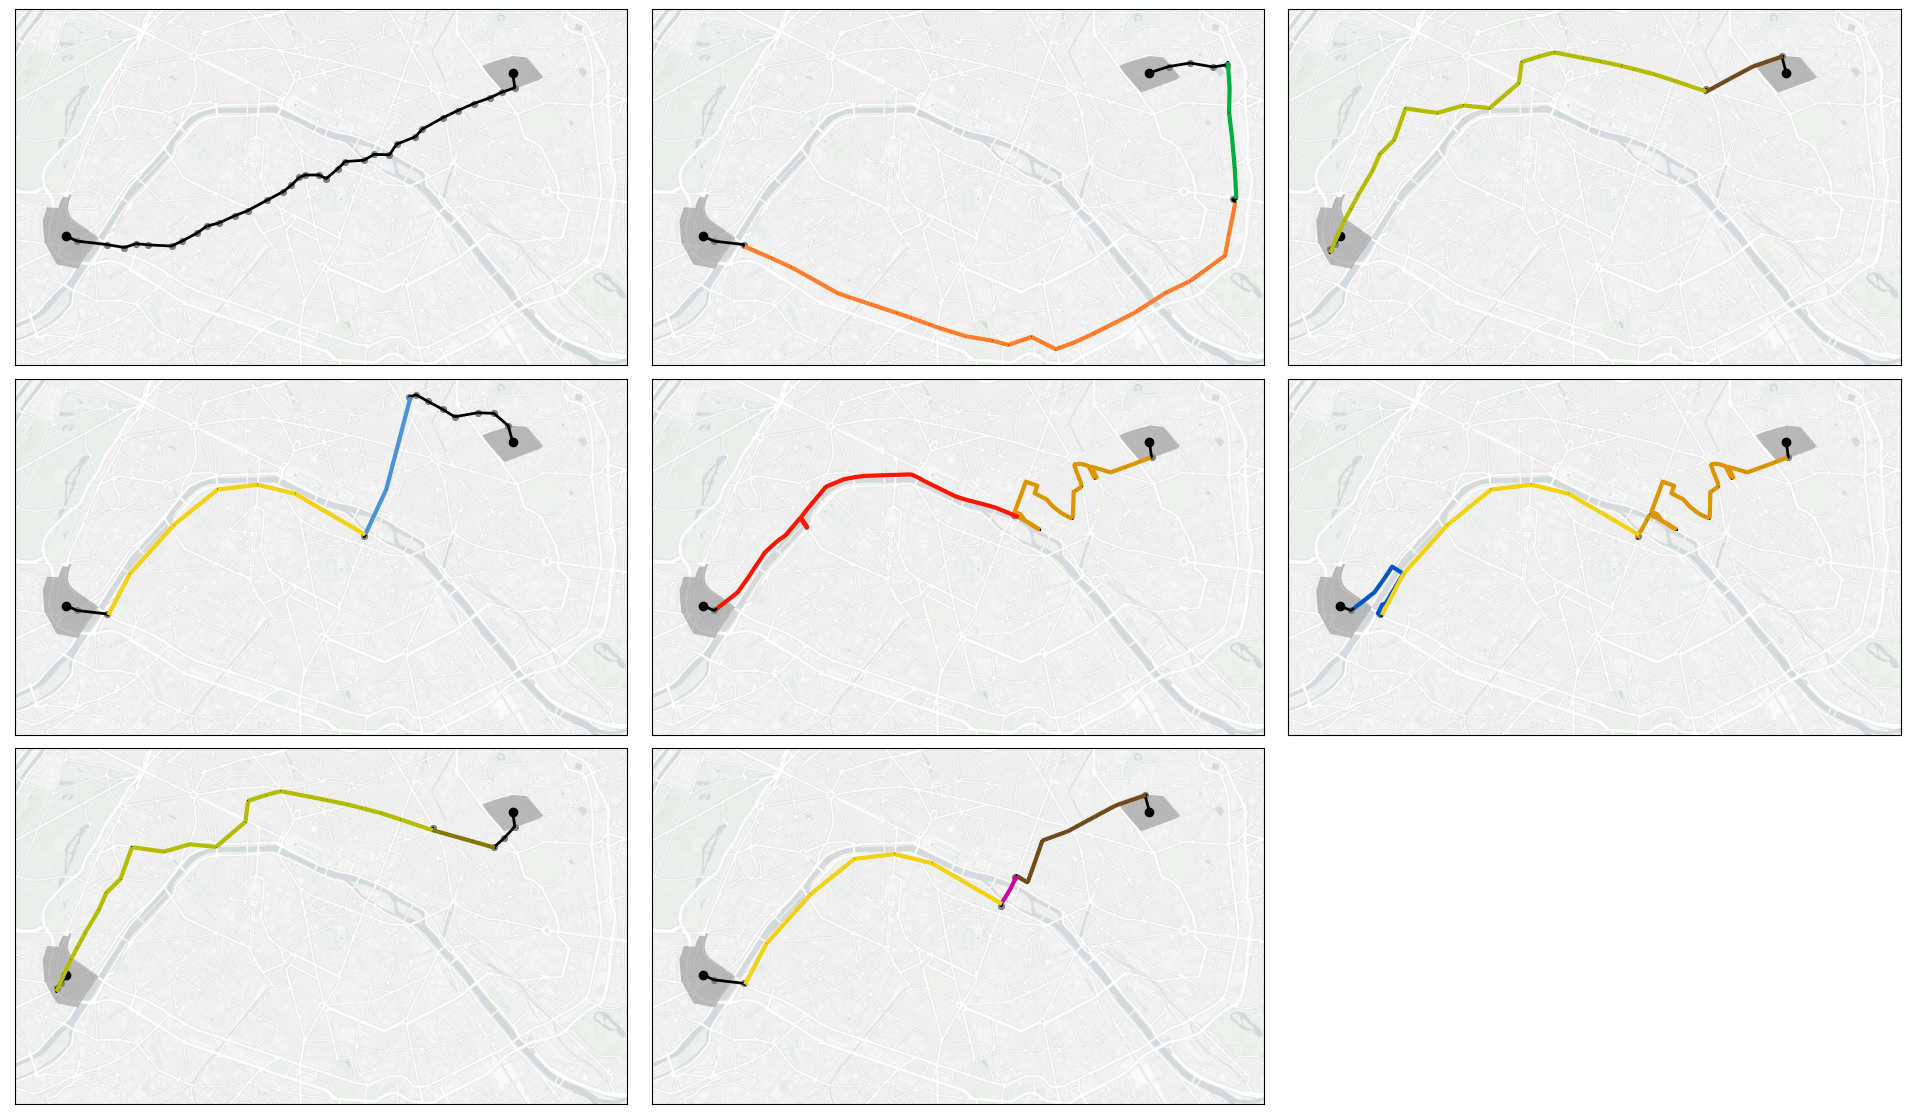

In [14]:
both.links['color'] = '#' + both.links['route_color']
origin, destination='zone_74',  'zone_105'
rows = 3
fig, axes = both.plot_separated_paths(
    origin, destination, rows=rows, figsize=[20, 20],
    title=None, constrained_layout=True, zoom=13, resize=True,
    basemap_url='http://a.basemaps.cartocdn.com/light_nolabels/tileZ/tileX/tileY.png', 
)

In [15]:
both.to_zippedpickles(training_folder + 'models/{scen}/pruning_pt_pathfinder'.format(scen=scenario))

pt_los: 100%|██████████| 30/30 [00:03<00:00,  9.02it/s]                 


# END